In [133]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt



# Part 1:  Data Import and Cleaning

In [6]:
#Load csv file and observe its shape and characteristics

relax = pd.read_csv('Downloads/relax_challenge/takehome_user_engagement.csv')
relax.shape

(207917, 3)

In [5]:
relax.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [15]:
# Check for null values

relax.isna().any()[lambda x: x]

Series([], dtype: bool)

In [9]:
users = pd.read_csv('Downloads/relax_challenge/takehome_users.csv', encoding='latin-1')
users.shape

(12000, 10)

In [10]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [16]:
#Check for null values

users.isna().any()[lambda x: x]

last_session_creation_time    True
invited_by_user_id            True
dtype: bool

In [27]:
#Determine number of null entries in last_session_creation_time
users[users.last_session_creation_time.isnull()].shape[0]

3177

In [235]:
#Determine number of null entries in invited_by_user_id
users[users.invited_by_user_id.isnull()].shape[0]


5583

In [37]:
# Rename columns of users to simplify joining tables

users.columns = ['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']



In [107]:
# Combine both df's and convert timestamps to datetime

full_df = relax.merge(users, how = 'inner', on = 'user_id')
full_df['time_stamp'] = pd.to_datetime(full_df.time_stamp).dt.strftime('%m/%d/%Y')

# Initialize empty lost of adopters
adopters = []

for user in users.user_id:
    # Develop a smaller df for each individual user
    test = full_df[full_df['user_id'] == user].copy()
    test = test.loc[:, ['time_stamp', 'user_id']]
    
    # Compute the number days between three logins
    test['two_logins_prior'] = test.time_stamp.shift(2)

    test = test.dropna()
    
    # For only those users with a sufficient number of logins, record their id's to adopters if they have three logins over 7 days
    if test.shape[0] > 0:
        test['time_delta'] = (pd.to_datetime(test.time_stamp) - pd.to_datetime(test.two_logins_prior))

        test['time_delta'] = test.time_delta.dt.days
        test = test.sort_values('time_delta')

        if test.iloc[0, :]['time_delta'] <= 7:
            adopters.append(user)



UsageError: Line magic function `%%timeit` not found.


# Part 2:  EDA and Statistics on Adopters vs. Nonadopters

In [155]:
# Create separate df's of adopters and non adopters for EDA
# Duplicates are dropped because we are not considering the values of the timestamps as a feature in this report

adopter_df = full_df.loc[full_df['user_id'].isin(adopters)]
adopter_df = adopter_df.drop('time_stamp', axis = 1).drop_duplicates()


nonadopter_df = full_df.loc[~full_df['user_id'].isin(adopters)]
nonadopter_df = nonadopter_df.drop('time_stamp', axis = 1).drop_duplicates()

In [159]:
adopter_df.head()

,user_id,visited,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
20,10,1,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0
310,20,1,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN
328,33,1,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79.0
349,42,1,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN


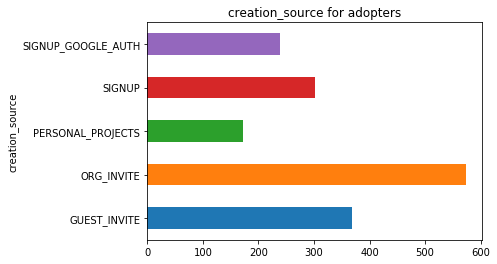

In [232]:
# Visualize the effect (or effectiveness) of creation source in determining adopters

adopt_source = adopter_df.groupby('creation_source')['creation_source'].count()
plt.title('creation_source for adopters')
ax = adopt_source.plot.barh(x='creation_source', y='user_id')


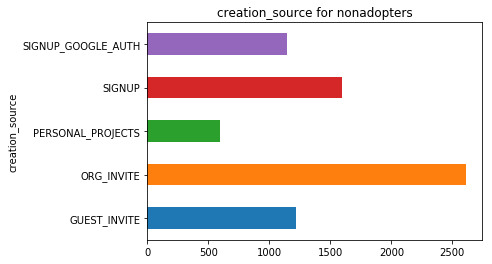

In [233]:
non_source = nonadopter_df.groupby('creation_source')['creation_source'].count()
plt.title('creation_source for nonadopters')
ax = non_source.plot.barh(x='creation_source', y='user_id')


## Remarks: 
The distributions look comparable, except that the adopters seem more slightly likely to have come from guest invites, and nonadopters seems slightly more likely to have signed up via the website.  Let's test this further statistically.

In [157]:
# Compute opt-in willingess to adopt

adopt_in_ratio = sum(adopter_df['enabled_for_marketing_drip'].values) / (adopter_df.shape[0])
nonadopt_in_ratio = sum(nonadopter_df['enabled_for_marketing_drip'].values) / (nonadopter_df.shape[0])

print('Willingness to opt-in and adoption likelihood:')
print('For adopters, willingess to opt in at', round(adopt_in_ratio*100, 2), '%')
print('For nonadopters, willingess to opt in at', round(nonadopt_in_ratio*100, 2), '%')


Willingness to opt-in and adoption likelihood:
For adopters, willingess to opt in at 15.52 %
For nonadopters, willingess to opt in at 15.12 %


In [158]:
# Compute enabled marketing drip and adoption 

adopt_market_ratio = sum(adopter_df['opted_in_to_mailing_list'].values) / (adopter_df.shape[0])

nonadopt_market_ratio = sum(nonadopter_df['opted_in_to_mailing_list'].values) / (nonadopter_df.shape[0])

print('Enabled marketing drip and adoption likelihood:')
print('For adopters, marketing participation at', round(adopt_market_ratio*100, 2), '%')
print('For nonadopters, marketing participation at', round(nonadopt_market_ratio*100, 2), '%')


Enabled marketing drip and adoption likelihood:
For adopters, marketing participation at 25.91 %
For nonadopters, marketing participation at 25.07 %


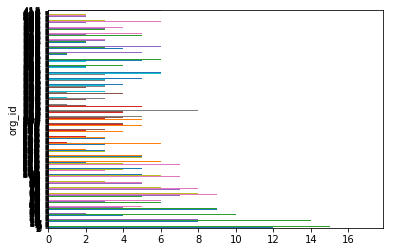

In [184]:
# Study of organizational id impact:

adopt_orgs = adopter_df.groupby('org_id')['org_id'].count()
ax = adopt_orgs.plot.barh(x='org_id', y='user_id')


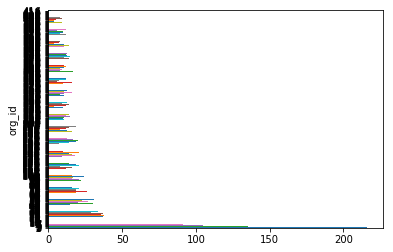

In [185]:
nonadopt_orgs = nonadopter_df.groupby('org_id')['org_id'].count()
ax = nonadopt_orgs.plot.barh(x='org_id', y='user_id')


## Remarks:
It appears there are at least a few organizations which encouraged a large number of employees to sign up, but who did not adopt.  These might be considered outliers.  Otherwise, it appears that the number of employees from organizations which do or do not adopt may be comparable.  Removing the outliers (user groups over 100), we will check the distributions next.

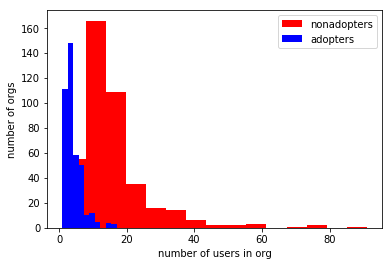

In [234]:
plt.hist(nonadopt_orgs.values[nonadopt_orgs.values < 100], bins = 15, label = 'nonadopters', color = 'red')
plt.hist(adopt_orgs.values, color = 'blue', label = 'adopters')
plt.xlabel('number of users in org')
plt.ylabel('number of orgs')
plt.legend()
plt.show()

Examining the distributions of typical organizatons whose users elect to adopt or not, there is a clear tendency for higher engagement among smaller groups of users.

In [230]:
# Let's see if the invited_by_user_id provides any new information, particularly if the invitation comes from an adopter.

everybody = pd.concat([adopter_df, nonadopter_df])

adopter_invite = everybody.loc[everybody['invited_by_user_id'].isin(adopters)]
adopter_invite_adopt = adopter_invite.loc[adopter_invite['user_id'].isin(adopters)]

aia_ratio = adopter_invite_adopt.shape[0] / adopter_invite.shape[0]


adopter_invite_nonadopt = adopter_invite.loc[~adopter_invite['user_id'].isin(adopters)]
naia_ratio = adopter_invite_nonadopt.shape[0] / adopter_invite.shape[0]

adoption_ratio = adopter_invite.shape[0] / everybody.shape[0]


no_adopter_invite = everybody.loc[~everybody['invited_by_user_id'].isin(adopters)]
no_adopter_invite_adopt = no_adopter_invite.loc[no_adopter_invite['user_id'].isin(adopters)]
no_aia_ratio = no_adopter_invite_adopt.shape[0] / no_adopter_invite.shape[0]

ratio_adopted_without_invite = no_aia_ratio
ratio_no_invite_no_adopt = 1 - no_aia_ratio

overall_ratio = everybody.loc[everybody['user_id'].isin(adopters)].shape[0] / everybody.shape[0]


print('Effectiveness of adopters inviting others:')
print('')
print('Ratio of invitees that adopted the technology:', round(aia_ratio*100, 2), '%')
print('Ratio of invitees that did not adopted the technology:', round(naia_ratio*100, 2), '%')
print('')
print('Ratio of adopters who did not receive an adopter invite:', round(ratio_adopted_without_invite*100,2), '%')
print('Ratio of user with no invite, no adoption:', round(ratio_no_invite_no_adopt*100, 2), '%')
print('')
print('Adoption rate for entire dataset:', round(overall_ratio*100, 2),  '%')

Effectiveness of adopters inviting others:

Ratio of invitees that adopted the technology: 28.02 %
Ratio of invitees that did not adopted the technology: 71.98 %

Ratio of adopters who did not receive an adopter invite: 17.78 %
Ratio of user with no invite, no adoption: 82.22 %

Adoption rate for entire dataset: 18.77 %
